# Step 5: Spectrum and light curve from DL3

This notebook must be used with a gammapy version v0.20 or higher. Here we will use the following conda environment:

`conda activate gammapy-v1.0`

In this notebook we analyze DL3 with `gammapy` to look for the target (Crab) position, the number of excess and backgroun events; to plot the ON and OFF regions, as well as the significance in terms of livetime; and to fit our spectral data with a LogParabola model given by  

## $ \Phi =  \Phi_0 \left(\frac{E}{E_{ref}}\right)^{\alpha + \beta\log_{10}(E/E_{ref})},     $

where we compare it with the archival Crab spectrum, which has $\Phi_0 = 3.23\times 10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$, $E_{ref} = 1$ TeV, $\alpha = -2.47$, and $\beta = -0.24$.


Furthermore, we will plot the number of events vs. energy, compute the SED ($E^2dN/dE$), and compute a light curve.

We will also use two different sets of DL3 files to compare SEDs with different interpolations or weights.


### As usual, let's start by loading some modules (and checking the `gammapy` version)

In [9]:
import itertools
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib import pyplot as plt

In [10]:
# We need to use gammapy v0.20 or later.

import gammapy

print(f"gammapy: v{gammapy.__version__}")

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from regions import CircleSkyRegion, PointSkyRegion

gammapy: v1.0


In [11]:
# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Get the default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load DL3 files

Here we load the DL3 files. The first thing we do is providing the directories where the DL3 runs and index files are stored.

In this example we use the data available in the directories  
`/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_wgt/`  
and  
`/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_int/`

In the first dataset we use a simple average between the three telescopes DL2 parameters, while in the second one we weighted this average on intensity.

If instead you wish to process only one set of DL3 files, please set `input_dir_1 = ""` below.

Let's start by creating DataStore objects from the input directories and take a look at one of them.

In [15]:
input_dir = '/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_wgt/'
input_dir_1 = '/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_int/'

double = True
if input_dir_1=='':
    double = False

data_store = DataStore.from_dir(input_dir)
if double:
    data_store_1 = DataStore.from_dir(input_dir_1)
# Show the observation table
data_store.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes10,bytes10
2923,2020-11-18,23:35:46.756,2020-11-18,23:52:39.749,83.96640878838603,22.2466773018085,45.06353160611354,44.93646839388646,86.4029882775053,83.63333333,22.01333333,1605742546.756451,1605743559.749314,451.3736107349396,1012.992862462995,409.0913326624333,0.906325321049095,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
2924,2020-11-18,23:56:14.698,2020-11-19,00:15:55.933,83.26503262048294,21.7876915585711,40.10371827458638,49.89628172541362,89.6596903830588,83.63333333,22.01333333,1605743774.698224,1605744955.932863,536.2971684932709,1181.234639644619,487.0149766340357,0.9081065596566663,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3093,2020-12-07,23:34:47.371,2020-12-07,23:36:13.672,83.97442701658245,22.2463480864551,28.89166955491227,61.10833044508773,95.75785391769863,83.63333333,22.01333333,1607384087.370709,1607384173.672199,39.02381253242493,86.3014895915903,36.69248074225411,0.9402587384758034,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,2021-03-15,22:03:46.914,2021-03-15,22:18:29.142,83.28829767818313,21.78779441212851,39.44157010036336,50.55842989963664,269.9795752580683,83.63333333,22.01333333,1615845826.914014,1615846709.142035,448.7389826774597,882.228020906448,431.4658751183312,0.9615074503755696,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
4071,2021-03-15,22:20:06.030,2021-03-15,22:33:51.792,83.99210573728418,22.25024365934386,42.25871695884816,47.74128304115184,272.2101025603572,83.63333333,22.01333333,1615846806.030235,1615847631.791612,412.6295664310455,825.761377334598,398.6902593758757,0.9662183513029978,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
4125,2021-03-17,22:40:16.224,2021-03-17,22:59:10.396,83.29047868056195,21.79155650040567,49.17288582588206,40.82711417411794,274.9188876256304,83.63333333,22.01333333,1616020816.224253,1616021950.396211,549.9685978889465,1134.171958684918,526.5106219583231,0.9573466993921711,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2


Let's take a look at the features of the observations (i.e. the runs).

In the cell below, if we set `obs_ids = None` this means that we will process all of the runs. If you want to use only some of the runs, please insert instead a list of comma-separated runs.

In [16]:
obs_ids = None   # `None` means "all" observations
obs_ids_1 = None

observations = data_store.get_observations(obs_ids, required_irf="point-like")
if double:
    observations_1 = data_store_1.get_observations(obs_ids_1, required_irf="point-like")
print(observations)

Observations
Number of observations: 16
Observation

	obs id            : 2923 
 	tstart            : 59171.98
	tstop             : 59171.99
	duration          : 1012.99 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 9.4%
Observation

	obs id            : 2924 
 	tstart            : 59172.00
	tstop             : 59172.01
	duration          : 1181.23 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 3093 
 	tstart            : 59190.98
	tstop             : 59190.98
	duration          : 86.30 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 6.0%
Observation

	obs id            : 3265 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.42 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.9%
Observation

	obs id            : 3266 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 845.84 s
	pointing (icrs)   : 83.3 deg, 21.8 

### Define a target region

Here we will collect the target position from observations metadata. To define the `on_region` we use `CircleSkyRegion` in case of global theta cuts, `PointSkyRegion` in case of dynamic theta cuts.

In [19]:
# Get metadata from the first observation
observation = observations[0]

event_meta = observation.events.table.meta
aeff_meta = observation.aeff.meta

# Collecting the target position
target_position = SkyCoord(
    u.Quantity(event_meta["RA_OBJ"], u.deg),
    u.Quantity(event_meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in aeff_meta:
    # Get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta["RAD_MAX"] * u.deg
    
    # Use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
    
else:
    # Use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)
    
print("Position of the ON region: \n",on_region)

Position of the ON region: 
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>
radius: 0.2 deg


Since we are providing a second input sample, let's collect also its position since the two datasets can have different types of theta cuts (in this case here they are identical).

In [20]:
if double:
    # Get metadata from the first observation
    observation_1 = observations_1[0]

    event_meta_1 = observation_1.events.table.meta
    aeff_meta_1 = observation_1.aeff.meta

    # Define a target position
    target_position_1 = SkyCoord(
        u.Quantity(event_meta["RA_OBJ"], u.deg),
        u.Quantity(event_meta["DEC_OBJ"], u.deg),
        frame="icrs",
    )

    if "RAD_MAX" in aeff_meta:
        # Get the global theta cut used for creating the IRFs
        on_region_radius = aeff_meta["RAD_MAX"] * u.deg

        # Use the circle sky region to apply the global theta cut
        on_region_1 = CircleSkyRegion(center=target_position, radius=on_region_radius)

    else:
        # Use the point sky region to apply dynamic theta cuts
        on_region_1 = PointSkyRegion(target_position_1)

    print("Position of the second ON region: \n",on_region_1)

Position of the second ON region: 
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>
radius: 0.2 deg


### Running the data reduction chain

Here we create the energy axes (reconstructed and true energy) and we set the number of OFF regions.

We also create the Gammapy Makers needed to process the data.

In [21]:
# ================
# === Settings ===
# ================

energy_min = "0.030 TeV"
energy_max = "30. TeV"
n_bins_pdec = 5

true_energy_min = "0.01 TeV"
true_energy_max = "100 TeV"
n_bins_pdec_true = 10

n_off_regions = 3

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    nbin=n_bins_pdec,
    per_decade=True,
    name="energy",
)

energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name="energy_true",
)

#print("Energy axis:")
#print(energy_axis.edges)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# Create a spectrum dataset maker
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

# Create a background maker
print(f"\nNumber of OFF regions: {n_off_regions}")

region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# Create a safe mask maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)


Number of OFF regions: 3


Below we create new makers for the second data sample:

In [22]:
if double:
    on_geom_1 = RegionGeom.create(region=on_region_1, axes=[energy_axis])
    dataset_empty_1 = SpectrumDataset.create(geom=on_geom_1, energy_axis_true=energy_axis_true)
    # Create a spectrum dataset maker
    dataset_maker_1 = SpectrumDatasetMaker(
        containment_correction=False,
        selection=["counts", "exposure", "edisp"],
        use_region_center=True,
    )

    # Create a background maker
    print(f"\nNumber of OFF regions: {n_off_regions}")

    region_finder_1 = WobbleRegionsFinder(n_off_regions=n_off_regions)
    bkg_maker_1 = ReflectedRegionsBackgroundMaker(region_finder=region_finder_1)

    # Create a safe mask maker
    safe_mask_maker_1 = SafeMaskMaker(methods=["aeff-max"], aeff_percent=3)


Number of OFF regions: 3


Now we apply the makers to the observations to create new datasets that contain the number of events, number of excess and background events, exposure and $\delta = 1/R_{OFF}$, where $R_{OFF}$ is the number of OFF regions. We will use this $\delta$ later to compute the Li & Ma significance.


In [23]:
datasets = Datasets()

counts = Map.create(skydir=target_position, width=3)

# Loop over every observation
print("Running the makers...")

n_observations = len(observations)

for i_obs, observation in enumerate(observations):
    
    if (i_obs % 10) == 0:
        print(f"{i_obs}/{n_observations}")
    
    obs_id = observation.obs_id
    
    # Fill the number of events in the map
    counts.fill_events(observation.events)

    # Run the makers to the observation data
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(f"{n_observations}/{n_observations}")

# Get the information table
info_table = datasets.info_table(cumulative=True)
print(datasets.energy_ranges)
# Show the table
info_table

Running the makers...
0/16
10/16
16/16
(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,287,246.0,19.120512922614985,41.0,102.5000022910535,102.5000022910535,nan,1022.79736328125,289498400.0,918.1010812922179,1012.9928624629974,0.31260174489289394,0.044657392127556275,0.2679443527653377,15,11,wstat,388.170810788279,123,11.0,33.0,0.3333333432674408
stacked,596,515.6666870117188,28.039956964408375,80.33332824707031,209.24999763630322,209.24999763630322,nan,8161.96484375,568076928.0,1990.7880060471784,2194.2275021076202,0.2993789384854651,0.04035252774431601,0.2590264184058472,15,11,wstat,814.1455812254699,241,11.0,33.000003814697266,0.3333333134651184
stacked,626,541.3333129882812,28.708063742434803,84.66667175292969,220.00000399537376,220.00000399537376,nan,124.49567413330078,582496064.0,2071.9337357791574,2280.5289916992188,0.302133214585934,0.040863600167739204,0.2612696070536788,15,12,wstat,855.6043023538452,254,12.0,36.0,0.3333333432674408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,3535,3001.666748046875,65.95861340110007,533.3333129882812,1283.7501102499632,1283.7501102499632,nan,11144.3388671875,2771325696.0,11207.209445789787,11817.969825267792,0.31542196271954154,0.047588413116401475,0.2678335550492019,15,13,wstat,4568.764719667647,1600,13.0,39.000003814697266,0.3333333134651184
stacked,3846,3268.0,68.88532399945436,578.0,1395.00012002885,1395.00012002885,nan,11144.3388671875,3035139584.0,12005.075242367711,12643.731202602386,0.32036450604048605,0.04814630381991704,0.27221820222056897,15,13,wstat,4995.59633358944,1734,13.0,39.0,0.3333333432674408
stacked,4097,3459.333251953125,70.28835380086662,637.666748046875,1502.5001236554199,1502.5001236554199,nan,11144.3388671875,3530694912.0,13090.871023557875,13777.903161287308,0.312966187859248,0.048710796011919466,0.26425539184732855,15,13,wstat,5167.144050765441,1913,13.0,38.999996185302734,0.3333333730697632


Again for the second sample:

In [25]:
if double:
    datasets_1 = Datasets()

    counts_1 = Map.create(skydir=target_position_1, width=3)

    # Loop over every observation
    print("Running the makers...")

    n_observations_1 = len(observations_1)

    for i_obs, observation in enumerate(observations_1):

        if (i_obs % 10) == 0:
            print(f"{i_obs}/{n_observations_1}")

        obs_id = observation.obs_id

        # Fill the number of events in the map
        counts_1.fill_events(observation.events)

        # Run the makers to the observation data
        dataset = dataset_maker_1.run(dataset_empty_1.copy(name=str(obs_id)), observation)
        dataset_on_off = bkg_maker_1.run(dataset, observation)
        dataset_on_off = safe_mask_maker_1.run(dataset_on_off, observation)

        datasets_1.append(dataset_on_off)

    print(f"{n_observations_1}/{n_observations_1}")

    # Get the information table
    info_table_1 = datasets_1.info_table(cumulative=True)
    print(datasets_1.energy_ranges)

    # Show the table
    info_table_1

Running the makers...
0/16
10/16
16/16
(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,375,300.0,19.3727077158201,75.0,150.0000033527612,150.0000033527612,nan,941.30810546875,290014784.0,917.4142425893486,1012.2350344657898,0.40875755203187625,0.08175151040637525,0.327006041625501,15,12,wstat,436.4220173166261,225,12.0,36.0,0.3333333432674408
stacked,842,683.6666870117188,29.760781567439395,158.3333282470703,329.2500133104619,329.2500133104619,nan,8450.755859375,568213696.0,1990.101167344309,2193.4696741104126,0.4230940686917978,0.07956044187359493,0.34353363448554625,15,12,wstat,980.4458159561755,475,12.0,36.000003814697266,0.3333333134651184
stacked,888,722.6666870117188,30.681775970032778,165.33331298828125,346.00001977011505,346.00001977011505,nan,116.02606201171875,582987456.0,2071.3763990266857,2279.9088938236237,0.42870045271214846,0.07981809248476972,0.34888236022737873,15,13,wstat,1041.730572935292,496,13.0,39.00000762939453,0.333333283662796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,4882,3886.66650390625,69.33880512143591,995.3333740234375,1967.0001682527316,1967.0001682527316,nan,10970.923828125,2786489856.0,11206.959898746329,11817.672394514084,0.43562215302886265,0.08881386058450882,0.3468082815519875,15,14,wstat,5398.666994694316,2986,14.0,42.0,0.3333333432674408
stacked,5255,4184.0,71.94969428843238,1071.0001220703125,2117.000179585064,2117.000179585064,nan,10970.923828125,3051238912.0,12004.825695324253,12643.433771848679,0.4377406330894721,0.08921413348695727,0.3485265097709517,15,14,wstat,5820.909040489313,3213,14.0,41.999996185302734,0.3333333730697632
stacked,5594,4431.66650390625,73.62453470797551,1162.33349609375,2270.250198248768,2270.250198248768,nan,10970.923828125,3546960384.0,13089.667367302241,13776.609112262726,0.4273599811996532,0.08879778710017021,0.338562194099483,15,14,wstat,6034.309829744186,3487,14.0,41.999996185302734,0.3333333730697632


### Counts map

Let's create a counts map including the ON-OFF regions. From the colors, we see that almost all of the events come from the Crab position, as expected. In the legend we list the run number for each set of OFF regions.

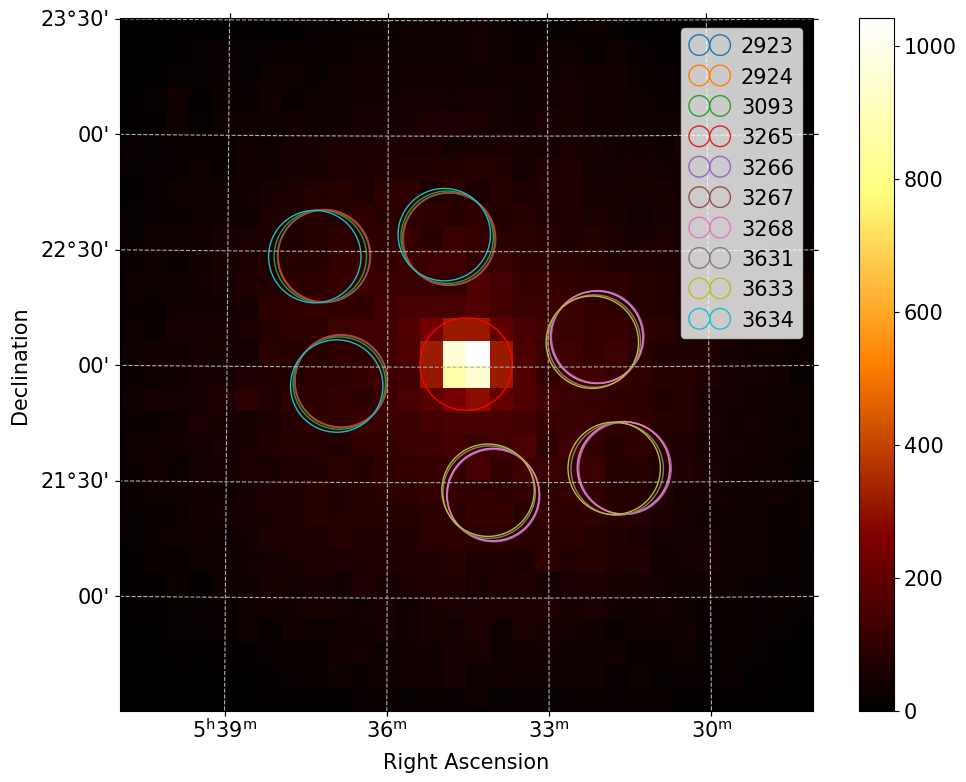

In [34]:
plt.figure()

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor="red")

# Plot the OFF positions (only the first part of observations)
if n_observations < 10:
    plot_spectrum_datasets_off_regions(datasets, ax)
else:
    plot_spectrum_datasets_off_regions(datasets[0:10], ax)

ax.grid()

Now let's plot the number of events and significance (i.e. sqrt(TS), in $\sigma$ units) in terms of livetime, which is the total amount of usefull time collecting data from the target, i.e. livetime $= t_{on} - t_{dead}$.

As expected, the number of excess events (and so the significance) increase faster than the background in terms of the livetime, reaching a 50 $\sigma$ signaficance in less than 2 hours (this is a high intensity source).

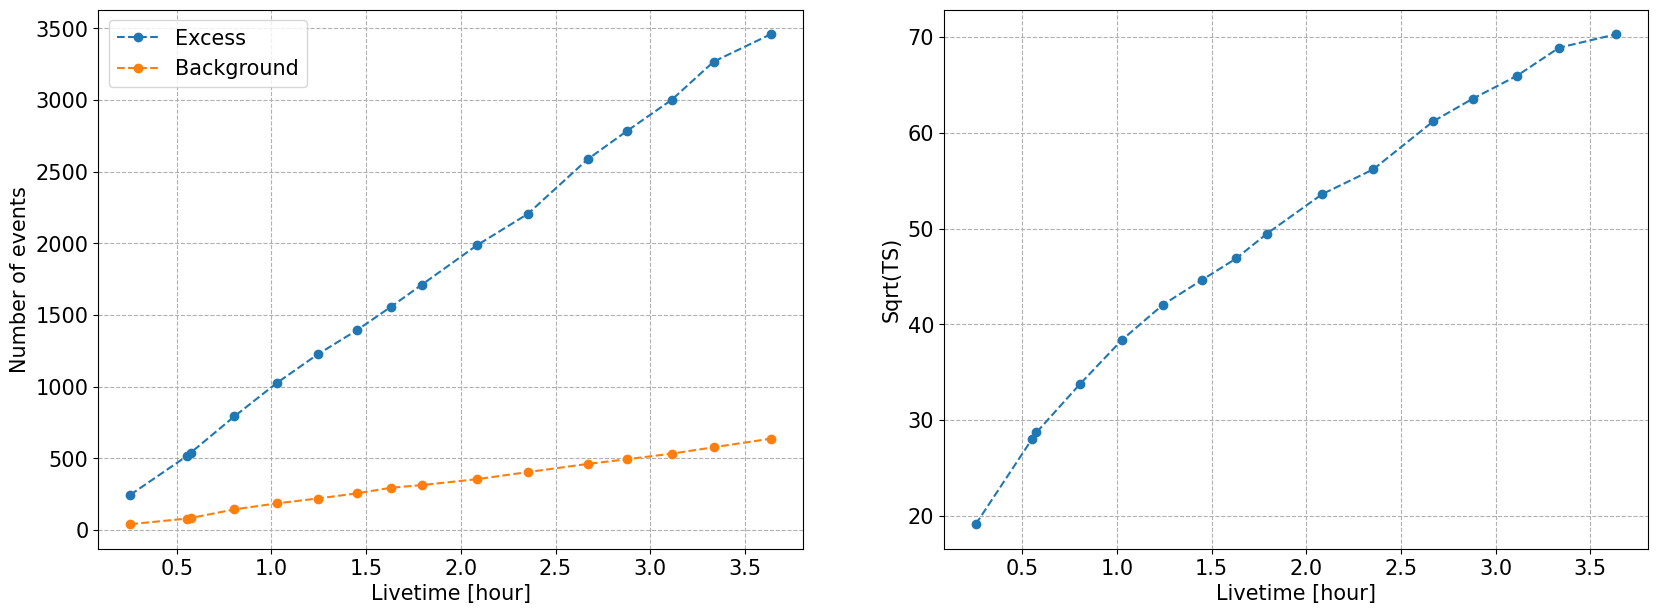

In [35]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

### Fitting the spectrum

We now fit the LogParabola model defined in the top of this notebook to our data. We start by creating a `SkyModel` and adding it to our datasets, we create a `Fit` that we will run on our data 

In [37]:
source_name="Crab Nebula"

spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit="cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit="TeV"),
)

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# Add the model to the stacked dataset
stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

if double:    
    stacked_dataset_1 = datasets_1.stack_reduce()
    stacked_dataset_1.models = [sky_model]

# Create a fit object to run on the datasets
fit = Fit()

Here we apply the `fit` on the first sample to get the LogParabola parameters.

In [38]:
results = fit.run(datasets=stacked_dataset)
print(results)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the fitted parameters
stacked_dataset.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 158
	total stat : 6.13

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,3.1816e-11,cm-2 s-1 TeV-1,9.325e-13,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.5277e+00,,2.983e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,1.2827e-01,,1.900e-02,nan,nan,False,False,


Same for the second sample:

In [40]:
if double:    
    results_1 = fit.run(datasets=stacked_dataset_1)
    print(results_1)

    # Keep the best fit model
    best_fit_model_1 = stacked_dataset_1.models[0].spectral_model.copy()

    # Show the fitted parameters
    stacked_dataset_1.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 5.31

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,3.2155e-11,cm-2 s-1 TeV-1,8.694e-13,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.4966e+00,,2.749e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,9.6802e-02,,1.477e-02,nan,nan,False,False,


Now let's check if the observations are in good agreement with the predictions. We do it by plotting the number of excess events and comparing it to the number of predicted events.

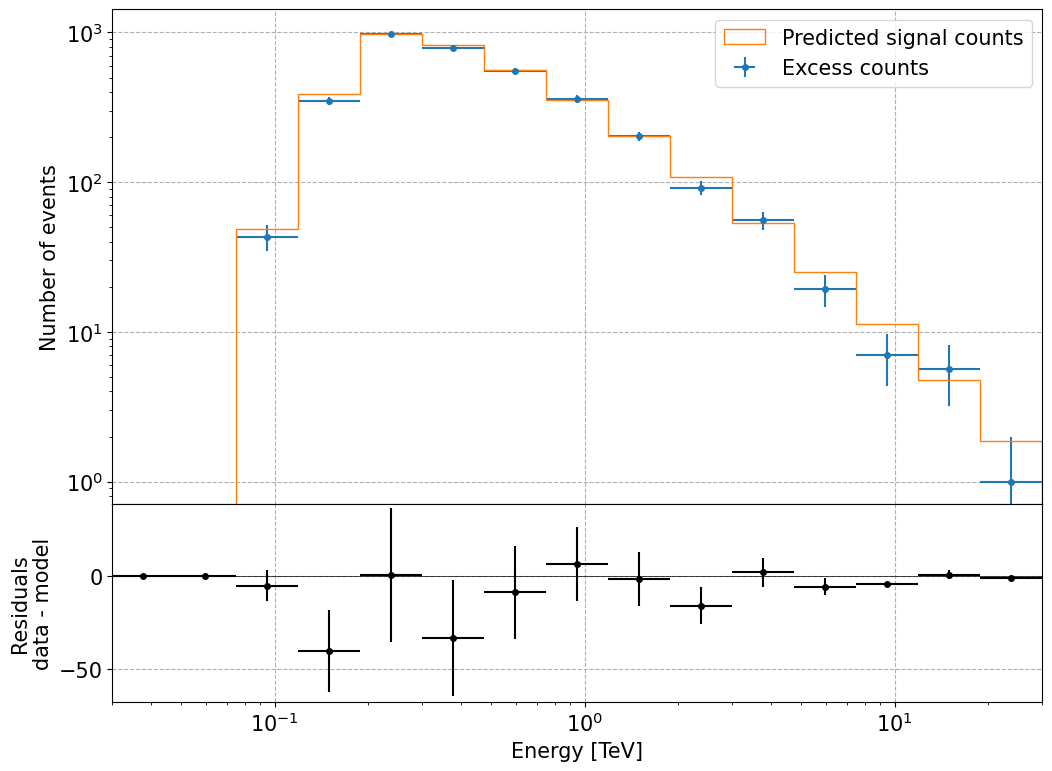

In [41]:
plt.figure()

# Plot the number of excess and predicted events
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

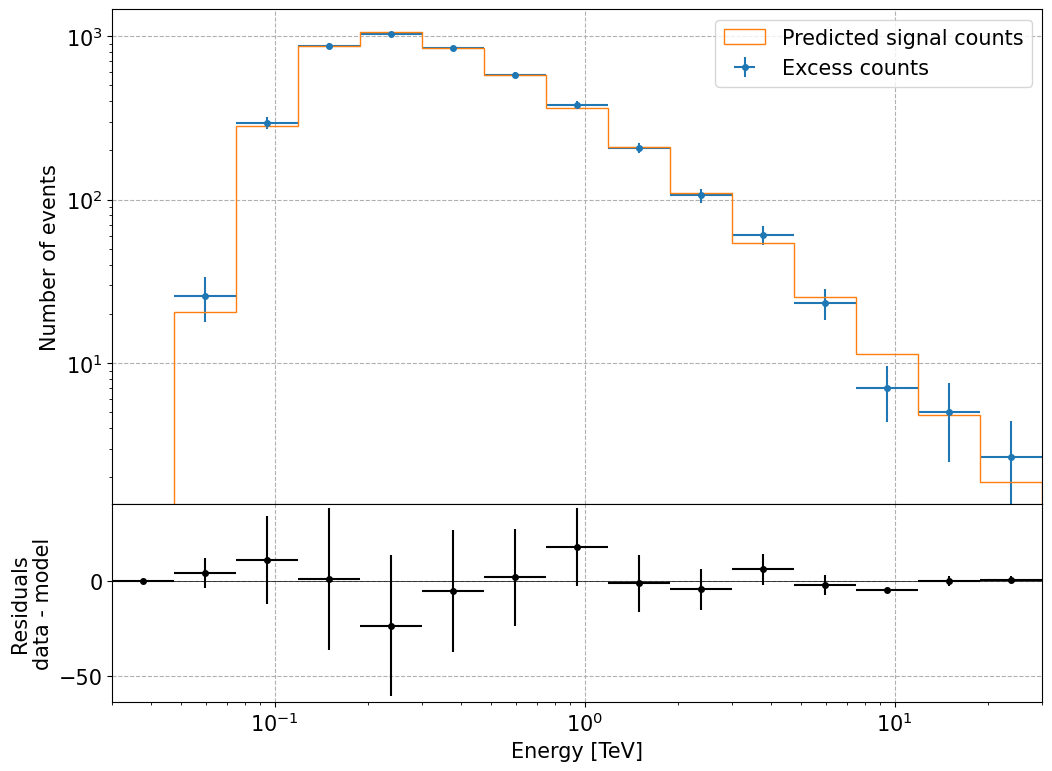

In [42]:
if double:
    plt.figure()

    # Plot the number of excess and predicted events
    ax_spectrum, ax_residuals = stacked_dataset_1.plot_fit()

    ax_spectrum.set_ylabel("Number of events")
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    ax_residuals.grid()

### Estimating the flux points

We create a `FluxPointsEstimator` object to be applied on our datasets in order to evaluate the SEDs (`sed_type="e2dnde"`)

In [44]:
# Create a flux point estimator
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source=source_name, selection_optional="all"
)

For the first data sample we have:

In [45]:
# Run the flux point estimator to the datasets
print("Running the flux points estimator...")
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# Show the flux points table
flux_points.to_table(sed_type="e2dnde", formatted=True)

Running the flux points estimator...


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.038,0.030,0.048,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.060,0.048,0.075,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.095,0.075,0.119,5.351e-11,1.058e-11,1.095e-11,1.023e-11,7.618e-11,36.595,6.049,64.99952898694048,42.999474,0.000,False,65.0,True,0.200 .. 5.000,20.291 .. 214.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.487,7.536,11.943,4.000e-12,1.512e-12,1.708e-12,1.327e-12,7.827e-12,19.408,4.405,7.0020905345917255,7.0020905,0.000,False,7.0,True,0.200 .. 5.000,6.363 .. 69.608
15.036,11.943,18.929,4.885e-12,2.131e-12,2.426e-12,1.867e-12,1.037e-11,11.469,3.387,5.990745314433161,5.6572404,0.000,False,6.0,True,0.200 .. 5.000,7.179 .. 19.512
23.830,18.929,30.000,1.337e-12,1.337e-12,1.815e-12,nan,6.023e-12,2.773,1.665,0.9998360238209194,0.999836,0.000,True,1.0,True,0.200 .. 5.000,0.707 .. 12.337


While for the second:

In [48]:
if double:
    # Run the flux point estimator to the datasets
    print("Running the flux points estimator...")
    flux_points_1 = flux_points_estimator.run(datasets=stacked_dataset_1)
    flux_points_1.to_table(sed_type="e2dnde", formatted=True)
    

Running the flux points estimator...


### Computing the SED

Below we show the SEDs for the two datasets in the same plot, showing the flux points and best fit models. For comparison, we plot the Crab reference SED (MAGIC, JHEAp 2015).

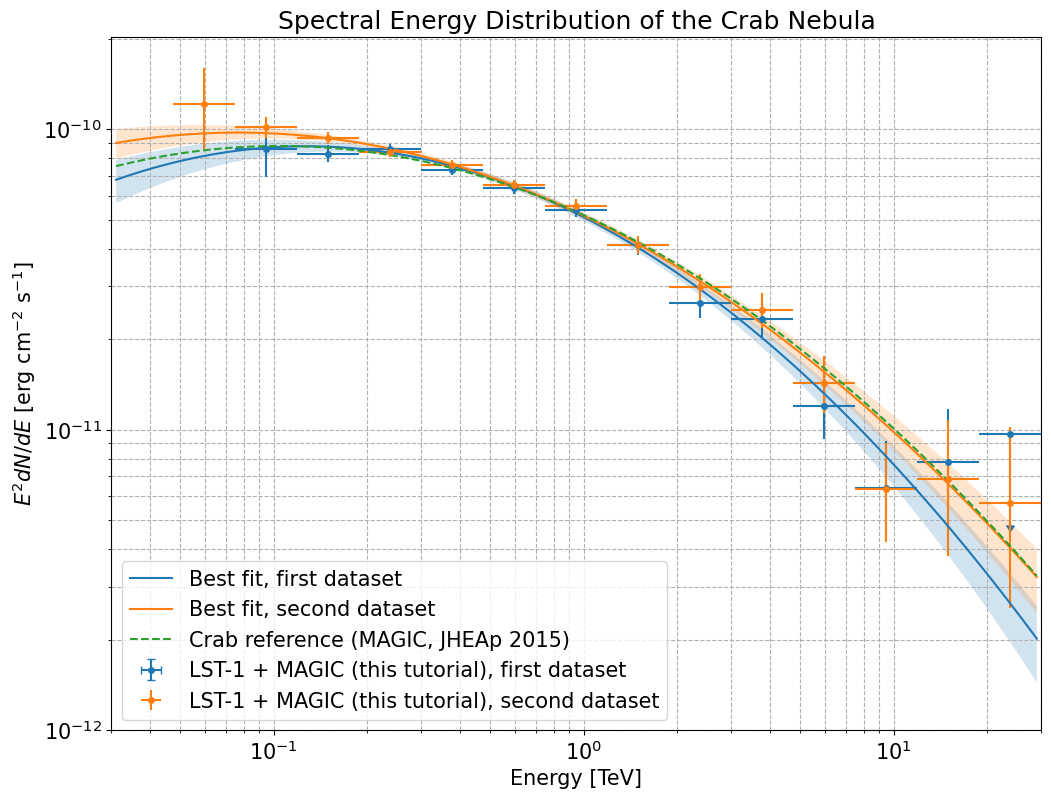

In [53]:
# ================
# === Settings ===
# ================

sed_type = "e2dnde"
yunits = u.Unit("erg cm-2 s-1")

crab_model = create_crab_spectral_model("magic_lp")
#print(crab_model)
reference_models = {
    "Crab reference (MAGIC, JHEAp 2015)": crab_model,
    
}

# ============
# === Main ===
# ============

plt.figure()

energy_bounds = energy_axis.edges[[0, -1]]

lines = itertools.cycle(["--", "-.", ":"])

# Plot the flux points
ax = flux_points.plot(sed_type=sed_type, label="LST-1 + MAGIC (this tutorial), first dataset")
if double:
    ax = flux_points_1.plot(sed_type=sed_type, label="LST-1 + MAGIC (this tutorial), second dataset")


# Plot the best fit model and its error, first sample
best_fit_model.plot(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    color=colors[0],
    label="Best fit, first dataset"
)

best_fit_model.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    facecolor=colors[0],
)

if double:
    # Plot the best fit model and its error, second sample
    best_fit_model_1.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        color=colors[1],
        label="Best fit, second dataset "
    )

    best_fit_model_1.plot_error(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        facecolor=colors[1],
    )


# Plot the reference spectra
for label, model in reference_models.items():

    model.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        label=label,
        linestyle=next(lines)
    )

ax.set_title(f"Spectral Energy Distribution of the {source_name}")

ax.set_ylim(1e-12)
ax.set_ylabel("$E^2dN/dE$ [erg cm$^{-2}$ s$^{-1}$]")
ax.grid(which="both")
ax.legend(loc="lower left")

### Computing the light curve

For the light curve, we assume that the spectral shape parameters, $\alpha$ and $\beta$, do not change over the different time bins, i.e. we freeze them at their best-fit values achieved above.

We start with the first data sample:

In [56]:
frozen_params = ["alpha", "beta"]

sky_model = SkyModel(
    spectral_model=best_fit_model.copy(), name=source_name
)

# Freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True
    
# Add the model to the datasets
datasets.models = [sky_model]

print(sky_model)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.18e-11   +/- 9.3e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.528                   
    beta                  (frozen):      0.128                   




And do the same for the second:

In [57]:
if double:
    sky_model_1 = SkyModel(
        spectral_model=best_fit_model_1.copy(), name=source_name
    )

    # Freeze the spectral parameters
    for param in frozen_params:
        sky_model_1.parameters[param].frozen = True

    # Add the model to the datasets
    datasets_1.models = [sky_model_1]

    print(sky_model_1)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.22e-11   +/- 8.7e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.497                   
    beta                  (frozen):      0.097                   




Now we create a `LightCurveEstimator`.

We must set energy edges and time intervals to be used to compute the light curve. If we adopt `time_intervals=None` we will get a run-wise LC, if instead we give it a list of Astropy Time objects, we can create e.g. a daily binned LC.

In [62]:
energy_edges = energy_axis.edges[[1,-1]]

#time_intervals = [
#    Time([59171.98, 59172.01], format="mjd", scale="utc"),
#    Time([59190.98, 59190.99], format="mjd", scale="utc"),
#    Time([59198.89, 59198.94], format="mjd", scale="utc"),
#    Time([59258.91, 59258.99], format="mjd", scale="utc"),
#    Time([59288.91, 59288.94], format="mjd", scale="utc"),
#    Time([59290.94, 59290.96], format="mjd", scale="utc"),
#]   # e.g. daily light curve 

time_intervals=None# `None` automatically makes a "run-wise" LC.

# ============
# === Main ===
# ============

# Create a light curve estimator
light_curve_estimator = LightCurveEstimator(
    energy_edges=energy_edges,
    time_intervals=time_intervals,
    source=source_name,
    selection_optional="all",
)

Now we run this estimator on the first data sample (`sed_type="flux"`)

In [63]:
# Run the light curve estimator to the datasets
print("Running the light curve estimator...")
light_curve = light_curve_estimator.run(datasets=datasets)

# Show the light curve table
light_curve.to_table(sed_type="flux", format="lightcurve")


Running the light curve estimator...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,16]","float64[1,16]",float64[1],bool[1],"float64[1,16]",bool[1],"float64[1,11]","float64[1,11]"
59171.983645145054,59171.995369599485,1.1943215116604917,0.04754679577383339,30.000000000000004,1.0037218158105268e-09,7.149395705929247e-11,7.281911819627752e-11,7.018168848898323e-11,1.1520030655271265e-09,377.0715631360974,19.4183305960141,284.40131901243444 .. nan,242.53201293945312 .. nan,11.099258649238388,False,287.0 .. nan,True,0.2 .. 4.999999999999999,219.27607137173726 .. 1177.2482823740156
59171.997857434086,59172.011529131305,1.1943215116604917,0.04754679577383339,30.000000000000004,1.1440845808024409e-09,7.638882954388337e-11,7.775038057947401e-11,7.50473837742464e-11,1.302354669993157e-09,429.23746048505626,20.71804673431007,nan .. nan,nan .. nan,8.103422410845878,False,nan .. nan,True,0.2 .. 4.999999999999999,265.83542100924933 .. 1047.9484026822809
59190.98295781008,59190.983956669916,1.1943215116604917,0.04754679577383339,30.000000000000004,1.1656073477894416e-09,2.586115332892367e-10,2.7373339914264063e-10,2.440661524686977e-10,1.7443704117310614e-09,36.28313449611681,6.0235483310185876,nan .. nan,nan .. nan,7.369881111553461,False,nan .. nan,True,0.2 .. 4.999999999999999,30.119833805494682 .. 100.2719251524608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59288.919758079806,59288.929969052275,1.1943215116604917,0.04754679577383339,30.000000000000004,9.904994436137499e-10,7.47181553657894e-11,7.618139492999949e-11,7.326412262362312e-11,1.1456587276115527e-09,322.1824463035608,17.949441392521408,nan .. nan,nan .. nan,10.98400365987734,False,nan .. nan,True,0.2 .. 4.999999999999999,189.69882265488081 .. 1077.628958467428
59288.931090443475,59288.940647866824,1.1943215116604917,0.04754679577383339,30.000000000000004,1.305805194378772e-09,8.624704714484019e-11,8.781786669741737e-11,8.469583499091245e-11,1.4846223775745673e-09,429.5994961514421,20.726782098324914,nan .. nan,nan .. nan,19.109677815321575,False,nan .. nan,True,0.2 .. 4.999999999999999,300.4732337404262 .. 842.2862199372149
59290.94509731868,59290.958224308946,1.1943215116604917,0.04754679577383339,30.000000000000004,8.673189121044583e-10,7.162594326758537e-11,7.301388344324372e-11,7.026391129049323e-11,1.0161752873356056e-09,244.12431298091747,15.624478006670094,nan .. 254.9698396230139,nan .. 196.6268310546875,7.438025151156201,False,nan .. 251.0,True,0.2 .. 4.999999999999999,134.05511387178436 .. 1177.4716585504798


Now for the second data sample:

In [64]:
if double:
    # Run the light curve estimator to the datasets
    print("Running the light curve estimator...")
    light_curve_1 = light_curve_estimator.run(datasets=datasets_1)

    # Show the light curve table
    light_curve_1.to_table(sed_type="flux", format="lightcurve")

Running the light curve estimator...


### LC plot

Finally, we plot the LCs and compare them to the Crab reference flux.

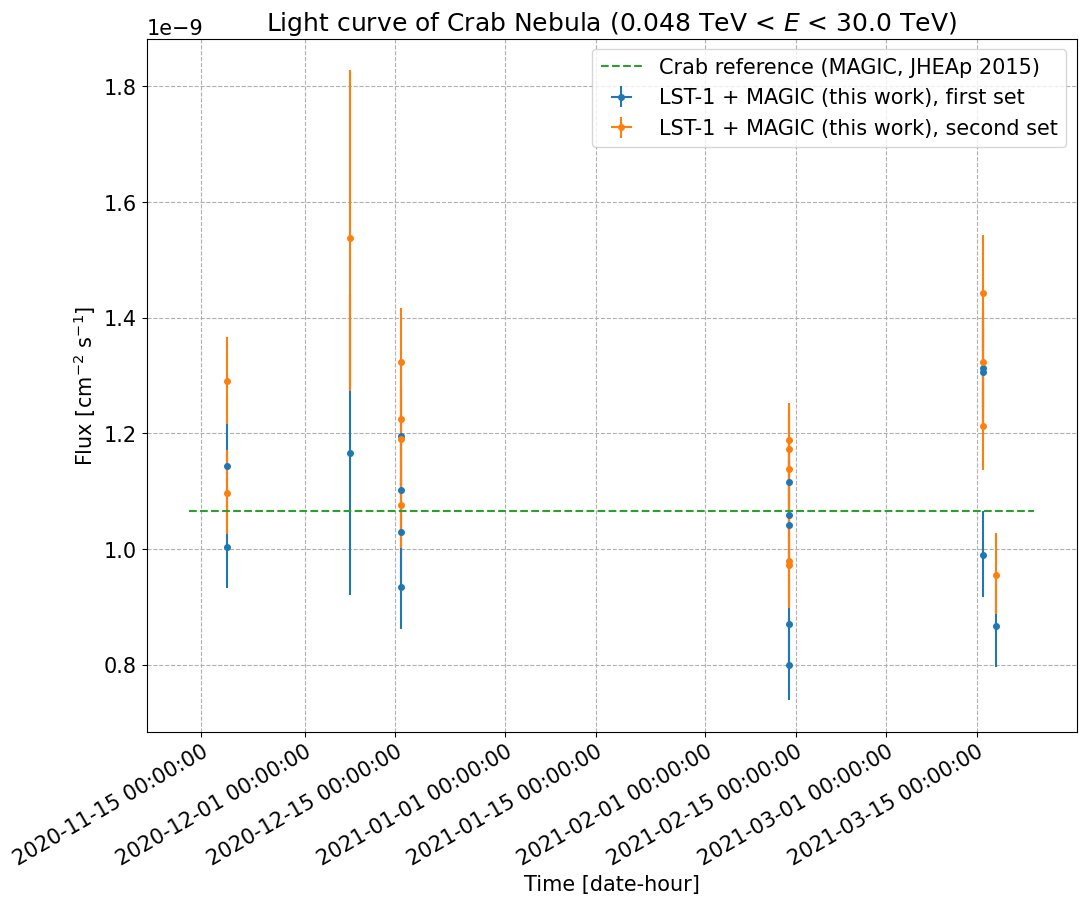

In [66]:
plt.figure()

lines = itertools.cycle(["--", "-.", ":"])

# Plot the light curve
ax = light_curve.plot(sed_type="flux", label="LST-1 + MAGIC (this work), first set")
if double:
    ax = light_curve_1.plot(sed_type="flux", label="LST-1 + MAGIC (this work), second set")


xlim = plt.xlim()

# Plot the reference flux
for label, model in reference_models.items():
    
    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.plot(xlim, np.repeat(integ_flux, 2), label=label, linestyle=next(lines))

energy_range = f"{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}"

ax.set_title(f"Light curve of {source_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Time [date-hour]")
ax.set_yscale("linear")
ax.legend()
ax.grid()
